In [0]:
from google.colab import drive
drive.mount('/content/drive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/drive


In [0]:
!cp /content/drive/'My Drive'/FashionKaggle/utls.py .

We created an utls.py file with some functions, which we will need here

In [0]:
from utls import *

In [0]:
# import required packages
import numpy as np
import pandas as pd

from pathlib import Path
from fastai.vision import *
from fastai.callbacks.hooks import *
from fastai.utils.mem import *

from itertools import groupby
from progressbar import ProgressBar
import cv2
import os
import json
import torchvision

from PIL import ImageFile

Let's create a folder where we will load target images and as it multiclass labeling task let's have a look at classes that we have:

In [0]:
path = Path("/content/drive/My Drive/FashionKaggle")
path_img = path/'train'
path_lbl = Path("/content/drive/My Drive/FashionKaggle/labels/")
path_test = path/'test'

# create a folder for the mask images
if  not os.path.isdir(path_lbl):
    os.makedirs(path_lbl)
    
# category is in util
size = 224

# train dataframe
df = pd.read_csv(path/'train.csv')

# get and show categories
with open(path/"label_descriptions.json") as f:
    label_descriptions = json.load(f)

label_names = [x['name'] for x in label_descriptions['categories']]
print(label_names)

['shirt, blouse', 'top, t-shirt, sweatshirt', 'sweater', 'cardigan', 'jacket', 'vest', 'pants', 'shorts', 'skirt', 'coat', 'dress', 'jumpsuit', 'cape', 'glasses', 'hat', 'headband, head covering, hair accessory', 'tie', 'glove', 'watch', 'belt', 'leg warmer', 'tights, stockings', 'sock', 'shoe', 'bag, wallet', 'scarf', 'umbrella', 'hood', 'collar', 'lapel', 'epaulette', 'sleeve', 'pocket', 'neckline', 'buckle', 'zipper', 'applique', 'bead', 'bow', 'flower', 'fringe', 'ribbon', 'rivet', 'ruffle', 'sequin', 'tassel']


Example of mask:

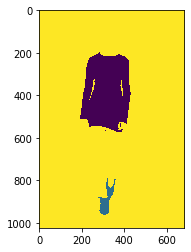

In [0]:
img_name = "0054564ae183ad9a1b152eef0bc11e1d.jpg"

img_df = df[df.ImageId == img_name]
img_mask = ImageMask()
mask = img_mask.make_mask_img(img_df)

plt.imshow(mask)
plt.show()

We faced with a problem with CUDA out of memory when we tried to create masked images. We found that it crashes usually after 800 images, so we just used commented loop:

In [0]:
# images = df.ImageId.unique()[:]

In [0]:
# Already created
# create_label(images, path_lbl, path_img)

In [0]:
# for i in range(len(df.ImageId.unique())//800+1):
#   print(i)
#   lowwer=i*800
#   upper=(1+i)*800
#   if upper > df.ImageId.nunique():
#     upper = df.ImageId.nunique()+1
#   images = df.ImageId.unique()[lowwer:upper]
#   create_label(images, path_lbl, path_img)

# Create Learner

As we use just 11k/45k images, we need to choose only corresponding masked images:

In [0]:
images_list = []
for (dirpath, dirnames, filenames) in os.walk(path_img):
    images_list.extend(filenames)
    break

In [0]:
images = [image for image in df.ImageId.unique() if image in images_list]

In [0]:
gpu_mem_get_free_no_cache()

15068

We will need a function, that will be map usual images with masked. Also, as we found, optimal batch size is 2
By default, dataset was splitted to 80% of training and **20% of validation**, as **was specified in task**.

In [0]:
get_y_fn = lambda x: path_lbl/f'{Path(x).stem}_P.png'

bs = 2
classes = list(range(category_num))
wd = 1e-2

images_df = pd.DataFrame(images)


src = (SegmentationItemList.from_df(images_df, path, folder='train')
       .split_by_rand_pct()
       .label_from_func(get_y_fn, classes=classes)
     )

In [0]:
def no_tfms(self, x, size, resize_method): return x
EmptyLabel.apply_tfms = no_tfms

In [0]:
data = (src.transform(tfms=get_transforms(), size=size, resize_method=ResizeMethod.SQUISH, tfm_y=True)
       .databunch(bs=bs,num_workers=4)
        .normalize(imagenet_stats)
       )

To avoid PIL erreor:

In [0]:
ImageFile.LOAD_TRUNCATED_IMAGES = True

We will use two metrics: accuracy of labeled pixels and IOU

In [0]:
def acc_fashion(input, target):
    target = target.squeeze(1)
    mask = target != (category_num - 1)
    return (input.argmax(dim=1)[mask]==target[mask]).float().mean()

We will use pre-trained resnet50:

Downloading: "https://download.pytorch.org/models/resnet50-19c8e357.pth" to /root/.cache/torch/checkpoints/resnet50-19c8e357.pth
100%|██████████| 97.8M/97.8M [00:00<00:00, 246MB/s]


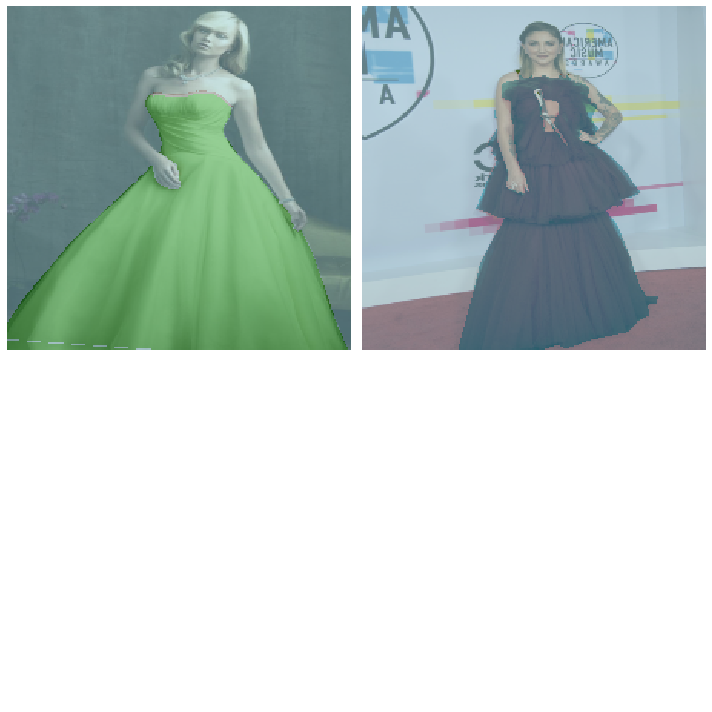

In [0]:
iou = partial(dice, iou=True)

learn = unet_learner(data, models.resnet50, metrics=[acc_fashion,iou], wd=wd, model_dir="/content/drive/My Drive/FashionKaggle/models")

# look at a batch
data.show_batch(3, figsize=(10,10))

epoch,train_loss,valid_loss,acc_fashion,dice,time


LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


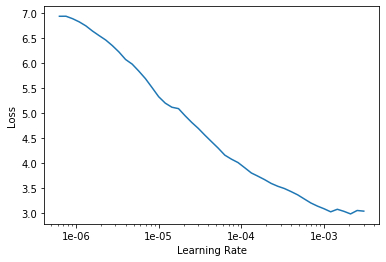

In [0]:
lr_find(learn)
learn.recorder.plot()

In [0]:
lr=1e-4
learn.fit_one_cycle(5, slice(lr), pct_start=0.9)

epoch,train_loss,valid_loss,acc_fashion,dice,time
0,0.562214,0.507514,0.371123,-1.048845,1:10:32
1,0.544267,0.453745,0.492727,-1.048540,1:08:09
2,0.478026,0.507428,0.410052,-1.048743,1:07:20
3,0.426482,0.502458,0.542646,-1.048353,1:06:55
4,0.397408,0.335573,0.599788,-1.048253,1:06:44


In [0]:
# check can we save model
learn.save('stage-1-224')

In [0]:
learn.path

PosixPath('/content/drive/My Drive/FashionKaggle')

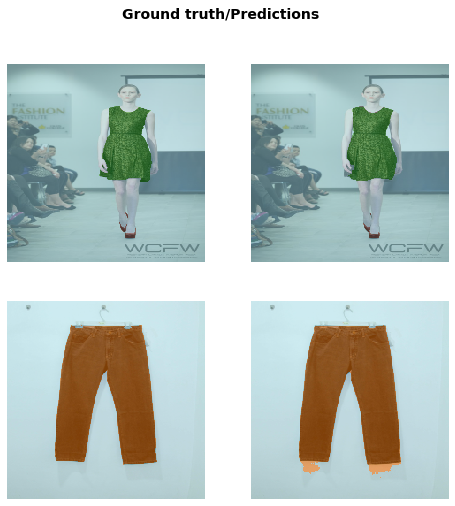

In [0]:
#  take a look at some results
learn.show_results()

In [0]:
# unfreeze earlier weights
# decrease the learning rate
# train for 10 more cycles unfrozen

learn.unfreeze()
lrs = slice(lr/400,lr/4)

learn.fit_one_cycle(3, lrs, pct_start=0.8)    

epoch,train_loss,valid_loss,acc_fashion,dice,time
0,0.350509,0.323007,0.607527,-1.048234,1:09:58
1,0.339423,0.335241,0.603501,-1.048302,1:08:46
2,0.344683,0.314420,0.620850,-1.048227,1:08:20


So, we get accuracy 62% with images of size 224 and as we can see from losses, we will get better performance if we would train more. But as one epoch continues for more than 1 hour, it's enough.

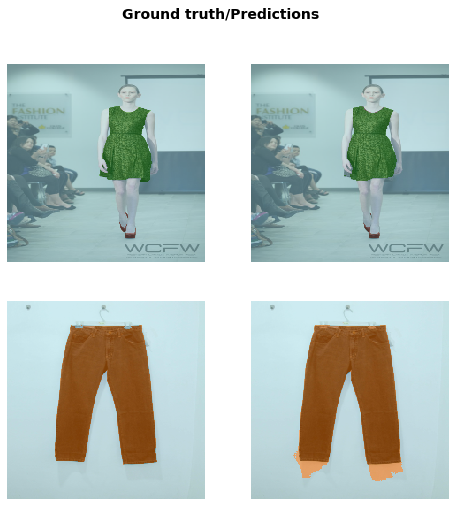

In [0]:
# more results

learn.show_results()

Losses were decreased, but this images looks worth than previous :)

In [0]:
learn.save('stage-2-224')